In [1]:
import datetime
import json
import logging
import os

from xcube.core.store import new_data_store
import numpy as np
from zappend.api import zappend


logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s.%(msecs)03d %(levelname)s %(name)s %(module)s - %(funcName)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [2]:
with open("cds-credentials.json") as f:
    credentials = json.load(f)

cds_store = new_data_store(
    "cds",
    **credentials,
    normalize_names=True,
)

In [3]:
store_team = new_data_store(
    "s3",
    root=os.environ["S3_USER_STORAGE_BUCKET"],
    max_depth=4,
    storage_options=dict(
        anon=False,
        key=os.environ["S3_USER_STORAGE_KEY"],
        secret=os.environ["S3_USER_STORAGE_SECRET"],
    ),
)

In [4]:
def get_time_ranges():
    years = np.arange(2016, 2025)
    months = np.arange(1, 13)
    time_ranges = []
    for year in years:
        for month in months:
            if year == 2016 and month < 11:
                continue
            if year == 2024 and month > 8:
                continue
            start = f"{year}-{month:02d}-01"
            if month + 1 == 13:
                end_year = year + 1
                end_month = 1
            else:
                end_year = year
                end_month = month + 1
            end = f"{end_year}-{end_month:02d}-01"
            dt = datetime.date.fromisoformat(end)
            dt = dt - datetime.timedelta(days=1)
            end = dt.isoformat()
            time_ranges.append([start, end])
    return time_ranges

time_ranges = get_time_ranges()
time_ranges

[['2016-11-01', '2016-11-30'],
 ['2016-12-01', '2016-12-31'],
 ['2017-01-01', '2017-01-31'],
 ['2017-02-01', '2017-02-28'],
 ['2017-03-01', '2017-03-31'],
 ['2017-04-01', '2017-04-30'],
 ['2017-05-01', '2017-05-31'],
 ['2017-06-01', '2017-06-30'],
 ['2017-07-01', '2017-07-31'],
 ['2017-08-01', '2017-08-31'],
 ['2017-09-01', '2017-09-30'],
 ['2017-10-01', '2017-10-31'],
 ['2017-11-01', '2017-11-30'],
 ['2017-12-01', '2017-12-31'],
 ['2018-01-01', '2018-01-31'],
 ['2018-02-01', '2018-02-28'],
 ['2018-03-01', '2018-03-31'],
 ['2018-04-01', '2018-04-30'],
 ['2018-05-01', '2018-05-31'],
 ['2018-06-01', '2018-06-30'],
 ['2018-07-01', '2018-07-31'],
 ['2018-08-01', '2018-08-31'],
 ['2018-09-01', '2018-09-30'],
 ['2018-10-01', '2018-10-31'],
 ['2018-11-01', '2018-11-30'],
 ['2018-12-01', '2018-12-31'],
 ['2019-01-01', '2019-01-31'],
 ['2019-02-01', '2019-02-28'],
 ['2019-03-01', '2019-03-31'],
 ['2019-04-01', '2019-04-30'],
 ['2019-05-01', '2019-05-31'],
 ['2019-06-01', '2019-06-30'],
 ['2019-

In [5]:
# extract ERA5 from CDS
data_id = "reanalysis-era5-single-levels:reanalysis"
bbox = [-5, 40, 35, 65]
variable_names = [
    "soil_temperature_level_1",
    "soil_temperature_level_2",
    "soil_temperature_level_3",
    "soil_temperature_level_4",
    "2m_dewpoint_temperature",
    "evaporation",
    "leaf_area_index_high_vegetation",
    "leaf_area_index_low_vegetation",
    "potential_evaporation",
    "skin_temperature",
    "surface_latent_heat_flux",
    "surface_pressure",
    "surface_sensible_heat_flux",
    "surface_net_solar_radiation",
    "2m_temperature",
    "total_precipitation",
]

for time_range in time_ranges:
    print(time_range)
    ds = cds_store.open_data(
        data_id,
        "dataset:netcdf:cds",
        variable_names=variable_names,
        bbox=bbox,
        spatial_res=0.25,
        time_range=time_range,
    )
    file_name = time_range[0][:-3].replace("-", "_")
    store_team.write_data(ds, f"cubes/aux/era5/{file_name}.zarr", replace=True)
    print(f"ERS5 for {time_range} is written to {file_name}.zarr")

['2024-07-01', '2024-07-31']


xcube-cds version 0.9.3
2024-09-16 06:25:27,133 INFO Request ID is bcdb24d6-1fbf-4320-acf6-b02d1d942dbd
INFO:cads_api_client.processing:Request ID is bcdb24d6-1fbf-4320-acf6-b02d1d942dbd
2024-09-16 06:25:27,197 INFO status has been updated to accepted
INFO:cads_api_client.processing:status has been updated to accepted
2024-09-16 06:25:28,747 INFO status has been updated to running
INFO:cads_api_client.processing:status has been updated to running
2024-09-16 06:25:31,113 INFO status has been updated to successful
INFO:cads_api_client.processing:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache/ed156a82a44c76254194ca5cb5bceee9.nc


ERS5 for ['2024-07-01', '2024-07-31'] is written to 2024_07.zarr


In [11]:
data_ids = store_team.list_data_ids()
data_ids = [data_id for data_id in data_ids if "cubes/aux/era5/" in data_id]
data_id_era5 = "cubes/aux/era5.zarr"
data_ids

['cubes/aux/era5/2016_11.zarr',
 'cubes/aux/era5/2016_12.zarr',
 'cubes/aux/era5/2017_01.zarr',
 'cubes/aux/era5/2017_02.zarr',
 'cubes/aux/era5/2017_03.zarr',
 'cubes/aux/era5/2017_04.zarr',
 'cubes/aux/era5/2017_05.zarr',
 'cubes/aux/era5/2017_06.zarr',
 'cubes/aux/era5/2017_07.zarr',
 'cubes/aux/era5/2017_08.zarr',
 'cubes/aux/era5/2017_09.zarr',
 'cubes/aux/era5/2017_10.zarr',
 'cubes/aux/era5/2017_11.zarr',
 'cubes/aux/era5/2017_12.zarr',
 'cubes/aux/era5/2018_01.zarr',
 'cubes/aux/era5/2018_02.zarr',
 'cubes/aux/era5/2018_03.zarr',
 'cubes/aux/era5/2018_04.zarr',
 'cubes/aux/era5/2018_05.zarr',
 'cubes/aux/era5/2018_06.zarr',
 'cubes/aux/era5/2018_07.zarr',
 'cubes/aux/era5/2018_08.zarr',
 'cubes/aux/era5/2018_09.zarr',
 'cubes/aux/era5/2018_10.zarr',
 'cubes/aux/era5/2018_11.zarr',
 'cubes/aux/era5/2018_12.zarr',
 'cubes/aux/era5/2019_01.zarr',
 'cubes/aux/era5/2019_02.zarr',
 'cubes/aux/era5/2019_03.zarr',
 'cubes/aux/era5/2019_04.zarr',
 'cubes/aux/era5/2019_05.zarr',
 'cubes/

In [12]:
ds = store_team.open_data(data_ids[0])
ds

<xarray.Dataset> Size: 737MB
Dimensions:  (time: 720, lat: 100, lon: 160)
Coordinates:
    expver   (time) <U4 12kB dask.array<chunksize=(720,), meta=np.ndarray>
  * lat      (lat) float64 800B 64.88 64.62 64.38 64.12 ... 40.62 40.38 40.12
  * lon      (lon) float64 1kB -4.875 -4.625 -4.375 -4.125 ... 34.38 34.62 34.88
    number   int64 8B ...
  * time     (time) datetime64[ns] 6kB 2016-11-01 ... 2016-11-30T23:00:00
Data variables: (12/16)
    d2m      (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
    e        (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
    lai_hv   (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
    lai_lv   (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
    pev      (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
    skt      (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
    ...       ...
    stl1     (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
    stl2     (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
    stl3     (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
    stl4     (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
    t2m      (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
    tp       (time, lat, lon) float32 46MB dask.array<chunksize=(180, 25, 40), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2024-09-09T06:57 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

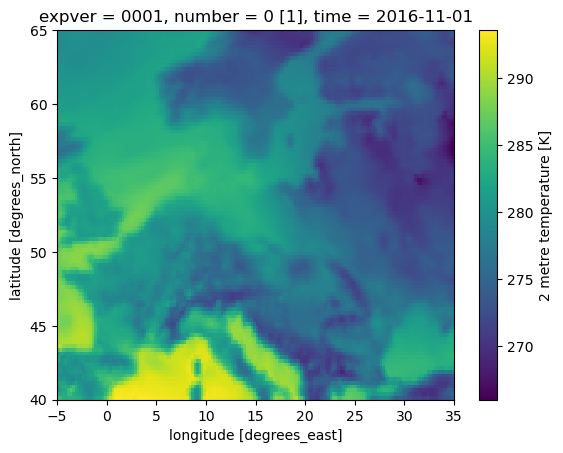

In [13]:
ds.t2m.isel(time=0).plot()

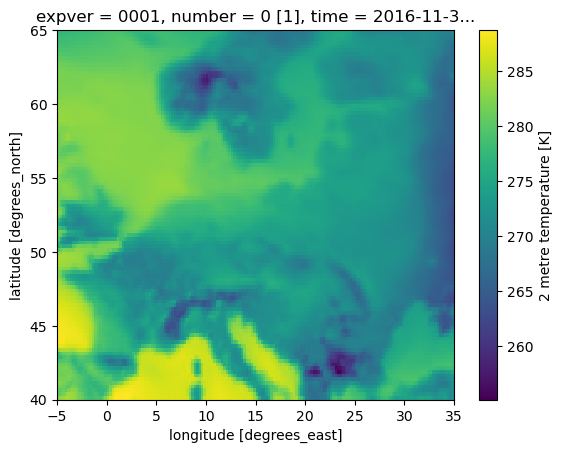

In [14]:
ds.t2m.isel(time=-1).plot()

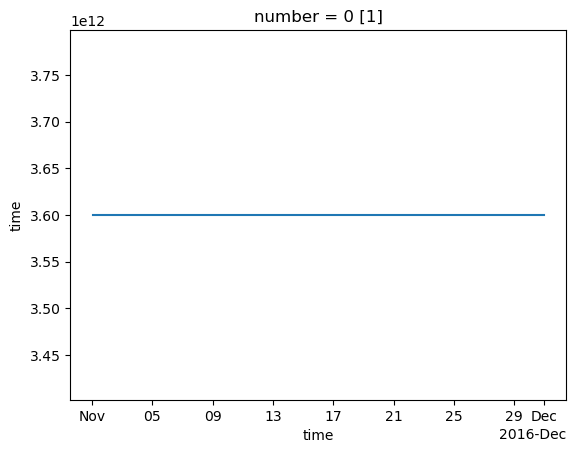

In [15]:
ds.time.diff("time").plot()